<a href="https://colab.research.google.com/github/saugatbh/EEG_NSL/blob/master/Performance_DatasetIIb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/saugatbh/EEG_NSL.git

fatal: destination path 'EEG_NSL' already exists and is not an empty directory.


In [2]:
from __future__ import print_function, division

import os
from scipy import io
from scipy.signal import butter, lfilter, filtfilt
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import itertools

from numpy import zeros

# EEGNet-specific imports
from EEG_NSL.EEGModels import EEGNet, ShallowConvNet, DeepConvNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

!pip install neural_structured_learning
import neural_structured_learning as nsl
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2509756574949490737
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6821662297638172826
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11057012618830270271
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1378632149065359922
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
# Band-pass Filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    y = filtfilt(b, a, data)
    return y

In [9]:
# Data preparation
people = 9  # Change the number of subjects to work on
class_id = [1, 2]  # Class information
no_of_sessions = 5
samplerate = 250
bands = [8, 24]
order = 4
no_electrodes = 3
epoch_length = 1000

data_path = 'EEG_NSL/BCIcompIV_DS2b/'  # Change path
subjects = dict(enumerate([str(s).zfill(2) for s in range(1, people+1)]))
sessions = dict(enumerate([str(s).zfill(2) for s in range(1, no_of_sessions+1)]))
print(subjects, sessions)

print('*'*80)
# print('Loading subjects:', subjects)
print('Loading subjects:', list(subjects.values()))

# Load the data set for subjects
filtered_epoch = {}
label = {}
train_data = {}
test_data = {}
train_label = {}
test_label = {}
for s, sub in enumerate(subjects.values()):
    filtered_epoch[s] = {}
    label[s] = {}
    train_data[s]=[]
    test_data[s]=[]
    train_label[s] = []
    test_label[s] = []
    for ses, sess in enumerate(sessions.values()):
        print('Subject %s Session %s' % (sub, sess))
        file = data_path + 'B' + str(sub) + str(sess) +'.mat'
        raw_eeg = io.loadmat(file)['rawEEG']
        raw_eeg[np.isnan(raw_eeg)] = 0
        # load event information
        triggers = io.loadmat(file)['triggers']
        y = io.loadmat(file)['classlabel']
        label[s][ses] = y
        # Extract the epochs
        filtered_epoch[s][ses] = np.empty((len(y), no_electrodes, epoch_length))
        for tr in range(len(y)):
            for elec in range(no_electrodes):
                epoch = raw_eeg[triggers[tr, 0]:triggers[tr, 0] + epoch_length, elec]
                filtered_epoch[s][ses][tr, elec, :] = butter_bandpass_filter(epoch, lowcut=bands[0], highcut=bands[1],
                                                                             fs=samplerate, order=order)
        if ses < 3:
            train_data[s].extend(filtered_epoch[s][ses])
            train_label[s].extend(label[s][ses])
        else:
            test_data[s].extend(filtered_epoch[s][ses])
            test_label[s].extend(label[s][ses])
    print(np.asarray(train_data[s]).shape, np.asarray(test_data[s]).shape)
    print(np.asarray(train_label[s]).shape, np.asarray(test_label[s]).shape)

{0: '01', 1: '02', 2: '03', 3: '04', 4: '05', 5: '06', 6: '07', 7: '08', 8: '09'} {0: '01', 1: '02', 2: '03', 3: '04', 4: '05'}
********************************************************************************
Loading subjects: ['01', '02', '03', '04', '05', '06', '07', '08', '09']
Subject 01 Session 01
Subject 01 Session 02
Subject 01 Session 03
Subject 01 Session 04
Subject 01 Session 05
(400, 3, 1000) (320, 3, 1000)
(400, 1) (320, 1)
Subject 02 Session 01
Subject 02 Session 02
Subject 02 Session 03
Subject 02 Session 04
Subject 02 Session 05
(400, 3, 1000) (280, 3, 1000)
(400, 1) (280, 1)
Subject 03 Session 01
Subject 03 Session 02
Subject 03 Session 03
Subject 03 Session 04
Subject 03 Session 05
(400, 3, 1000) (320, 3, 1000)
(400, 1) (320, 1)
Subject 04 Session 01
Subject 04 Session 02
Subject 04 Session 03
Subject 04 Session 04
Subject 04 Session 05
(420, 3, 1000) (320, 3, 1000)
(420, 1) (320, 1)
Subject 05 Session 01
Subject 05 Session 02
Subject 05 Session 03
Subject 05 Session 0

X_train shape: (300, 1, 3, 1000)
300 train samples
100 val samples
320 test samples
Train on 300 samples, validate on 100 samples
Epoch 1/100
300/300 - 0s - loss: 0.7150 - acc: 0.5200 - val_loss: 0.6933 - val_acc: 0.5200
Epoch 2/100
300/300 - 0s - loss: 0.6949 - acc: 0.5067 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/100
300/300 - 0s - loss: 0.6900 - acc: 0.5167 - val_loss: 0.6931 - val_acc: 0.5200
Epoch 4/100
300/300 - 0s - loss: 0.6859 - acc: 0.5733 - val_loss: 0.6930 - val_acc: 0.4800
Epoch 5/100
300/300 - 0s - loss: 0.6855 - acc: 0.5333 - val_loss: 0.6928 - val_acc: 0.5400
Epoch 6/100
300/300 - 0s - loss: 0.6753 - acc: 0.6067 - val_loss: 0.6927 - val_acc: 0.5300
Epoch 7/100
300/300 - 0s - loss: 0.6798 - acc: 0.5867 - val_loss: 0.6925 - val_acc: 0.5100
Epoch 8/100
300/300 - 0s - loss: 0.6805 - acc: 0.5467 - val_loss: 0.6919 - val_acc: 0.5700
Epoch 9/100
300/300 - 0s - loss: 0.6649 - acc: 0.6200 - val_loss: 0.6916 - val_acc: 0.6000
Epoch 10/100
300/300 - 0s - loss: 0.6641 - acc: 0.6

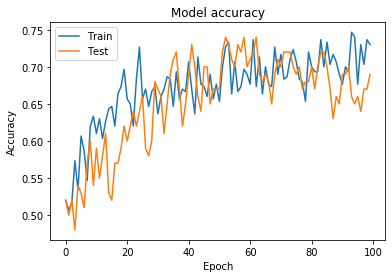


# Evaluate on test data
320/320 [==============================] - 1s 2ms/sample - loss: 0.6678 - acc: 0.6062
test loss, test acc: [0.667801252566278, 0.60625]
X_train shape: (300, 1, 3, 1000)
300 train samples
100 val samples
280 test samples
Train on 300 samples, validate on 100 samples
Epoch 1/100
300/300 - 0s - loss: 0.6992 - acc: 0.4533 - val_loss: 0.6930 - val_acc: 0.5500
Epoch 2/100
300/300 - 0s - loss: 0.6954 - acc: 0.4967 - val_loss: 0.6929 - val_acc: 0.6000
Epoch 3/100
300/300 - 0s - loss: 0.6910 - acc: 0.5367 - val_loss: 0.6928 - val_acc: 0.6000
Epoch 4/100
300/300 - 0s - loss: 0.6868 - acc: 0.5300 - val_loss: 0.6927 - val_acc: 0.5500
Epoch 5/100
300/300 - 0s - loss: 0.6781 - acc: 0.5733 - val_loss: 0.6925 - val_acc: 0.5300
Epoch 6/100
300/300 - 0s - loss: 0.6786 - acc: 0.5933 - val_loss: 0.6923 - val_acc: 0.5300
Epoch 7/100
300/300 - 0s - loss: 0.6836 - acc: 0.5733 - val_loss: 0.6921 - val_acc: 0.5200
Epoch 8/100
300/300 - 0s - loss: 0.6769 - acc: 0.5667 - val_loss: 0.6918

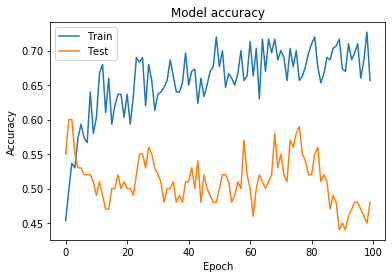


# Evaluate on test data
280/280 [==============================] - 1s 2ms/sample - loss: 0.7002 - acc: 0.5071
test loss, test acc: [0.7002456621932132, 0.50714284]
X_train shape: (300, 1, 3, 1000)
300 train samples
100 val samples
320 test samples
Train on 300 samples, validate on 100 samples
Epoch 1/100
300/300 - 0s - loss: 0.7187 - acc: 0.4700 - val_loss: 0.6928 - val_acc: 0.5500
Epoch 2/100
300/300 - 0s - loss: 0.6977 - acc: 0.5167 - val_loss: 0.6928 - val_acc: 0.5300
Epoch 3/100
300/300 - 0s - loss: 0.6900 - acc: 0.5000 - val_loss: 0.6926 - val_acc: 0.5600
Epoch 4/100
300/300 - 0s - loss: 0.6796 - acc: 0.5733 - val_loss: 0.6928 - val_acc: 0.5500
Epoch 5/100
300/300 - 0s - loss: 0.6893 - acc: 0.5633 - val_loss: 0.6928 - val_acc: 0.4900
Epoch 6/100
300/300 - 0s - loss: 0.6749 - acc: 0.6167 - val_loss: 0.6927 - val_acc: 0.5100
Epoch 7/100
300/300 - 0s - loss: 0.6794 - acc: 0.5433 - val_loss: 0.6927 - val_acc: 0.4900
Epoch 8/100
300/300 - 0s - loss: 0.6727 - acc: 0.5933 - val_loss: 0.

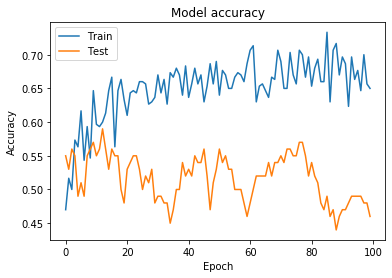


# Evaluate on test data
320/320 [==============================] - 1s 2ms/sample - loss: 0.6890 - acc: 0.5500
test loss, test acc: [0.6889769079745747, 0.55]
X_train shape: (300, 1, 3, 1000)
300 train samples
120 val samples
320 test samples
Train on 300 samples, validate on 120 samples
Epoch 1/100
300/300 - 0s - loss: 0.7126 - acc: 0.4600 - val_loss: 0.6930 - val_acc: 0.5167
Epoch 2/100
300/300 - 0s - loss: 0.6845 - acc: 0.5467 - val_loss: 0.6928 - val_acc: 0.5167
Epoch 3/100
300/300 - 0s - loss: 0.6871 - acc: 0.5433 - val_loss: 0.6927 - val_acc: 0.5500
Epoch 4/100
300/300 - 0s - loss: 0.6830 - acc: 0.5300 - val_loss: 0.6926 - val_acc: 0.5750
Epoch 5/100
300/300 - 0s - loss: 0.6787 - acc: 0.5800 - val_loss: 0.6924 - val_acc: 0.5917
Epoch 6/100
300/300 - 0s - loss: 0.6766 - acc: 0.5967 - val_loss: 0.6921 - val_acc: 0.5750
Epoch 7/100
300/300 - 0s - loss: 0.6721 - acc: 0.6233 - val_loss: 0.6916 - val_acc: 0.5583
Epoch 8/100
300/300 - 0s - loss: 0.6673 - acc: 0.6333 - val_loss: 0.6912 -

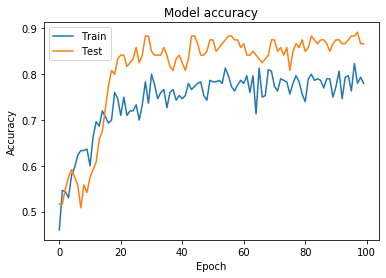


# Evaluate on test data
320/320 [==============================] - 1s 2ms/sample - loss: 0.4453 - acc: 0.7844
test loss, test acc: [0.4453400410591712, 0.784375]
X_train shape: (300, 1, 3, 1000)
300 train samples
120 val samples
320 test samples
Train on 300 samples, validate on 120 samples
Epoch 1/100
300/300 - 0s - loss: 0.6977 - acc: 0.5167 - val_loss: 0.6934 - val_acc: 0.4750
Epoch 2/100
300/300 - 0s - loss: 0.6877 - acc: 0.5333 - val_loss: 0.6937 - val_acc: 0.4917
Epoch 3/100
300/300 - 0s - loss: 0.6808 - acc: 0.6067 - val_loss: 0.6943 - val_acc: 0.4583
Epoch 4/100
300/300 - 0s - loss: 0.6788 - acc: 0.6000 - val_loss: 0.6943 - val_acc: 0.4500
Epoch 5/100
300/300 - 0s - loss: 0.6720 - acc: 0.6167 - val_loss: 0.6945 - val_acc: 0.4333
Epoch 6/100
300/300 - 0s - loss: 0.6721 - acc: 0.6233 - val_loss: 0.6947 - val_acc: 0.3917
Epoch 7/100
300/300 - 0s - loss: 0.6662 - acc: 0.6333 - val_loss: 0.6949 - val_acc: 0.3833
Epoch 8/100
300/300 - 0s - loss: 0.6614 - acc: 0.6433 - val_loss: 0.69

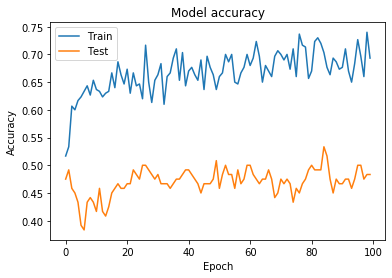


# Evaluate on test data
320/320 [==============================] - 1s 2ms/sample - loss: 0.7307 - acc: 0.5094
test loss, test acc: [0.7307498050387948, 0.509375]
X_train shape: (300, 1, 3, 1000)
300 train samples
100 val samples
320 test samples
Train on 300 samples, validate on 100 samples
Epoch 1/100
300/300 - 0s - loss: 0.6967 - acc: 0.5367 - val_loss: 0.6935 - val_acc: 0.5200
Epoch 2/100
300/300 - 0s - loss: 0.6930 - acc: 0.5267 - val_loss: 0.6932 - val_acc: 0.5300
Epoch 3/100
300/300 - 0s - loss: 0.6887 - acc: 0.5533 - val_loss: 0.6929 - val_acc: 0.5700
Epoch 4/100
300/300 - 0s - loss: 0.6945 - acc: 0.5400 - val_loss: 0.6929 - val_acc: 0.5900
Epoch 5/100
300/300 - 0s - loss: 0.6859 - acc: 0.5400 - val_loss: 0.6926 - val_acc: 0.5500
Epoch 6/100
300/300 - 0s - loss: 0.6725 - acc: 0.6033 - val_loss: 0.6923 - val_acc: 0.5700
Epoch 7/100
300/300 - 0s - loss: 0.6806 - acc: 0.5533 - val_loss: 0.6922 - val_acc: 0.5100
Epoch 8/100
300/300 - 0s - loss: 0.6714 - acc: 0.6100 - val_loss: 0.69

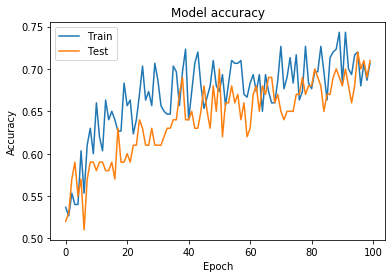


# Evaluate on test data
320/320 [==============================] - 1s 2ms/sample - loss: 0.6609 - acc: 0.6062
test loss, test acc: [0.6609014355111867, 0.60625]
X_train shape: (300, 1, 3, 1000)
300 train samples
100 val samples
320 test samples
Train on 300 samples, validate on 100 samples
Epoch 1/100
300/300 - 0s - loss: 0.7024 - acc: 0.4733 - val_loss: 0.6934 - val_acc: 0.4900
Epoch 2/100
300/300 - 0s - loss: 0.6935 - acc: 0.5233 - val_loss: 0.6935 - val_acc: 0.4400
Epoch 3/100
300/300 - 0s - loss: 0.6825 - acc: 0.5767 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 4/100
300/300 - 0s - loss: 0.6786 - acc: 0.6000 - val_loss: 0.6935 - val_acc: 0.5200
Epoch 5/100
300/300 - 0s - loss: 0.6723 - acc: 0.6000 - val_loss: 0.6935 - val_acc: 0.4700
Epoch 6/100
300/300 - 0s - loss: 0.6749 - acc: 0.5900 - val_loss: 0.6937 - val_acc: 0.4600
Epoch 7/100
300/300 - 0s - loss: 0.6618 - acc: 0.6667 - val_loss: 0.6941 - val_acc: 0.4900
Epoch 8/100
300/300 - 0s - loss: 0.6700 - acc: 0.6367 - val_loss: 0.694

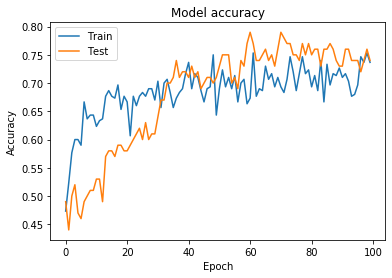


# Evaluate on test data
320/320 [==============================] - 1s 2ms/sample - loss: 0.5996 - acc: 0.6938
test loss, test acc: [0.5995534365065396, 0.69375]
X_train shape: (300, 1, 3, 1000)
300 train samples
140 val samples
320 test samples
Train on 300 samples, validate on 140 samples
Epoch 1/100
300/300 - 0s - loss: 0.7025 - acc: 0.5200 - val_loss: 0.6929 - val_acc: 0.5143
Epoch 2/100
300/300 - 0s - loss: 0.6904 - acc: 0.5333 - val_loss: 0.6928 - val_acc: 0.5500
Epoch 3/100
300/300 - 0s - loss: 0.6950 - acc: 0.5267 - val_loss: 0.6927 - val_acc: 0.5214
Epoch 4/100
300/300 - 0s - loss: 0.6821 - acc: 0.5800 - val_loss: 0.6927 - val_acc: 0.5643
Epoch 5/100
300/300 - 0s - loss: 0.6798 - acc: 0.6200 - val_loss: 0.6925 - val_acc: 0.5000
Epoch 6/100
300/300 - 0s - loss: 0.6839 - acc: 0.5533 - val_loss: 0.6923 - val_acc: 0.4857
Epoch 7/100
300/300 - 0s - loss: 0.6892 - acc: 0.5267 - val_loss: 0.6920 - val_acc: 0.5214
Epoch 8/100
300/300 - 0s - loss: 0.6795 - acc: 0.5733 - val_loss: 0.691

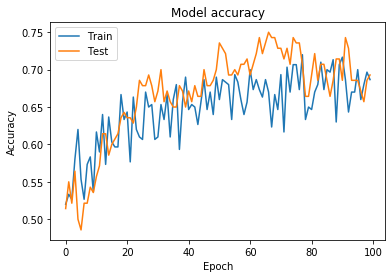


# Evaluate on test data
320/320 [==============================] - 1s 2ms/sample - loss: 0.5803 - acc: 0.7344
test loss, test acc: [0.5802803478203714, 0.734375]
X_train shape: (300, 1, 3, 1000)
300 train samples
100 val samples
320 test samples
Train on 300 samples, validate on 100 samples
Epoch 1/100
300/300 - 0s - loss: 0.7146 - acc: 0.4833 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/100
300/300 - 0s - loss: 0.6906 - acc: 0.5533 - val_loss: 0.6934 - val_acc: 0.5100
Epoch 3/100
300/300 - 0s - loss: 0.6846 - acc: 0.5633 - val_loss: 0.6937 - val_acc: 0.4900
Epoch 4/100
300/300 - 0s - loss: 0.6778 - acc: 0.5933 - val_loss: 0.6940 - val_acc: 0.4200
Epoch 5/100
300/300 - 0s - loss: 0.6781 - acc: 0.5700 - val_loss: 0.6944 - val_acc: 0.4500
Epoch 6/100
300/300 - 0s - loss: 0.6653 - acc: 0.6300 - val_loss: 0.6948 - val_acc: 0.4600
Epoch 7/100
300/300 - 0s - loss: 0.6678 - acc: 0.5767 - val_loss: 0.6954 - val_acc: 0.4500
Epoch 8/100
300/300 - 0s - loss: 0.6672 - acc: 0.5767 - val_loss: 0.69

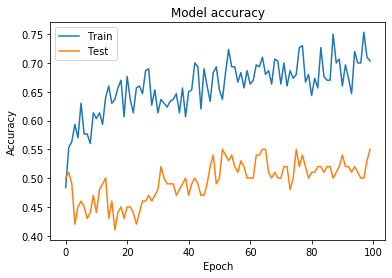


# Evaluate on test data
320/320 [==============================] - 1s 2ms/sample - loss: 0.6773 - acc: 0.5719
test loss, test acc: [0.6772685858421028, 0.571875]
[[0.70024566 0.50714284]
 [0.68897691 0.55000001]
 [0.44534004 0.78437501]
 [0.73074981 0.50937498]
 [0.66090144 0.60624999]
 [0.59955344 0.69375002]
 [0.58028035 0.734375  ]
 [0.67726859 0.57187498]
 [0.66780125 0.60624999]]


<Figure size 432x288 with 0 Axes>

In [10]:
from numpy import zeros
K.clear_session()
cols = 2
rows = 9
acc_all = zeros([rows, cols])
for s, sub in enumerate(subjects.values()):
  # split data of each subject in training and validation
  X_train      = np.asarray(train_data[s])[0:300,:,:]
  Y_train      = np.asarray(train_label[s])[0:300]
  X_val       = np.asarray(train_data[s])[300:,:,:]
  Y_val       = np.asarray(train_label[s])[300:]
  X_test      = np.asarray(test_data[s])
  Y_test      = np.asarray(test_label[s])
  
  # convert labels to one-hot encodings.
  Y_train      = np_utils.to_categorical(Y_train-1)
  Y_val       = np_utils.to_categorical(Y_val-1)
  Y_test      = np_utils.to_categorical(Y_test-1)

  kernels, chans, samples = 1, 3, 1000
  # convert data to NCHW (trials, kernels, channels, samples) format. Data 
  # contains 22 channels and 500 time-points. Set the number of kernels to 1.
  X_train      = X_train.reshape(X_train.shape[0], kernels, chans, samples)
  X_val       = X_val.reshape(X_val.shape[0], kernels, chans, samples)
  X_test       = X_test.reshape(X_test.shape[0], kernels, chans, samples)
   
  print('X_train shape:', X_train.shape)
  print(X_train.shape[0], 'train samples')
  print(X_val.shape[0], 'val samples')
  print(X_test.shape[0], 'test samples')

  # configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
  # model configurations may do better, but this is a good starting point)
  model = EEGNet(nb_classes = 2, Chans = 3, Samples = 1000, 
                 dropoutRate = 0.5, kernLength = 25, F1 = 8, 
                 D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')

  # compile the model and set the optimizers
  model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics = ['accuracy'])

  # count number of parameters in the model
  numParams    = model.count_params() 

  # set a valid path for your system to record model checkpoints
  checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                                 save_best_only=True)
  
  # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
  # the weights all to be 1
  class_weights = {0:1, 1:1, 2:1, 3:1}

  ################################################################################
  # fit the model. Due to very small sample sizes this can get
  # pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
  # Riemannian geometry classification (below)
  ################################################################################
  history = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, 
                      verbose = 2, validation_data=(X_val, Y_val),
                       class_weight = class_weights) #callbacks=[checkpointer],
  
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  figName = 'Accuracy_B' + sub + '.png'  
  plt.savefig(figName)

  print('\n# Evaluate on test data')
  results = model.evaluate(X_test, Y_test, batch_size=1)
  print('test loss, test acc:', results)

  acc_all[s - 1, 0] = results[0]
  acc_all[s - 1, 1] = results[1]

  from keras import backend as K 
  # Do some code, e.g. train and save model
  K.clear_session()

print(acc_all)

In [11]:
print(acc_all)

[[0.70024566 0.50714284]
 [0.68897691 0.55000001]
 [0.44534004 0.78437501]
 [0.73074981 0.50937498]
 [0.66090144 0.60624999]
 [0.59955344 0.69375002]
 [0.58028035 0.734375  ]
 [0.67726859 0.57187498]
 [0.66780125 0.60624999]]


X_train shape: (300, 1, 3, 1000)
300 train samples
99 val samples
320 test samples
Train on 19 steps, validate on 7 steps
Epoch 1/100
19/19 [==============================] - 0s 23ms/step - loss: 0.6981 - categorical_crossentropy: 0.6981 - categorical_accuracy: 0.5167 - val_loss: 0.6927 - val_categorical_crossentropy: 0.6927 - val_categorical_accuracy: 0.5152
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6817 - categorical_crossentropy: 0.6817 - categorical_accuracy: 0.5600 - val_loss: 0.6927 - val_categorical_crossentropy: 0.6927 - val_categorical_accuracy: 0.5455
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6749 - categorical_crossentropy: 0.6749 - categorical_accuracy: 0.6000 - val_loss: 0.6925 - val_categorical_crossentropy: 0.6925 - val_categorical_accuracy: 0.5253
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6739 - categorical_crossentropy: 0.6739 - categorical_accuracy: 0.6167 - val_loss: 0.

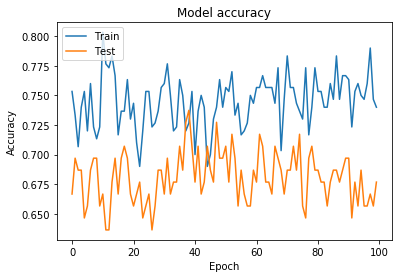


# Evaluate on test data
20/20 [==============================] - 0s 6ms/step - loss: 0.7165 - categorical_crossentropy: 0.7165 - categorical_accuracy: 0.5656
test loss, test acc: [0.7165314048528671, 0.71653146, 0.565625]
X_train shape: (300, 1, 3, 1000)
300 train samples
99 val samples
280 test samples
Train on 19 steps, validate on 7 steps
Epoch 1/100
19/19 [==============================] - 0s 24ms/step - loss: 0.7048 - categorical_crossentropy: 0.7048 - categorical_accuracy: 0.4700 - val_loss: 0.6935 - val_categorical_crossentropy: 0.6935 - val_categorical_accuracy: 0.4747
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6863 - categorical_crossentropy: 0.6863 - categorical_accuracy: 0.5567 - val_loss: 0.6938 - val_categorical_crossentropy: 0.6938 - val_categorical_accuracy: 0.4848
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.6923 - categorical_crossentropy: 0.6923 - categorical_accuracy: 0.5300 - val_loss: 0.6948 - val_categ

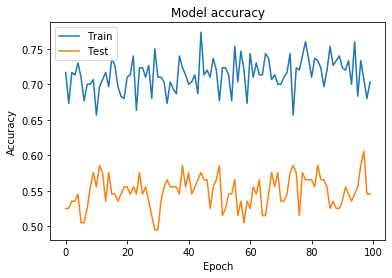


# Evaluate on test data
18/18 [==============================] - 0s 7ms/step - loss: 0.7155 - categorical_crossentropy: 0.7155 - categorical_accuracy: 0.5321
test loss, test acc: [0.7155280046992831, 0.715528, 0.5321429]
X_train shape: (300, 1, 3, 1000)
300 train samples
99 val samples
320 test samples
Train on 19 steps, validate on 7 steps
Epoch 1/100
19/19 [==============================] - 0s 24ms/step - loss: 0.6953 - categorical_crossentropy: 0.6953 - categorical_accuracy: 0.5000 - val_loss: 0.6911 - val_categorical_crossentropy: 0.6911 - val_categorical_accuracy: 0.6364
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6881 - categorical_crossentropy: 0.6881 - categorical_accuracy: 0.5200 - val_loss: 0.6907 - val_categorical_crossentropy: 0.6907 - val_categorical_accuracy: 0.6364
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6827 - categorical_crossentropy: 0.6827 - categorical_accuracy: 0.5733 - val_loss: 0.6905 - val_catego

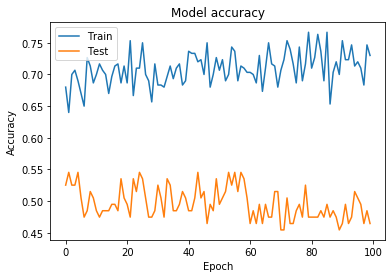


# Evaluate on test data
20/20 [==============================] - 0s 7ms/step - loss: 0.7145 - categorical_crossentropy: 0.7145 - categorical_accuracy: 0.5469
test loss, test acc: [0.7144752562046051, 0.7144753, 0.546875]
X_train shape: (300, 1, 3, 1000)
300 train samples
119 val samples
320 test samples
Train on 19 steps, validate on 8 steps
Epoch 1/100
19/19 [==============================] - 0s 25ms/step - loss: 0.7032 - categorical_crossentropy: 0.7032 - categorical_accuracy: 0.5033 - val_loss: 0.6933 - val_categorical_crossentropy: 0.6933 - val_categorical_accuracy: 0.5042
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6899 - categorical_crossentropy: 0.6899 - categorical_accuracy: 0.5167 - val_loss: 0.6931 - val_categorical_crossentropy: 0.6931 - val_categorical_accuracy: 0.5294
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6837 - categorical_crossentropy: 0.6837 - categorical_accuracy: 0.5700 - val_loss: 0.6931 - val_categ

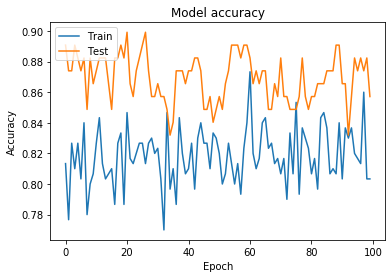


# Evaluate on test data
20/20 [==============================] - 0s 6ms/step - loss: 0.4163 - categorical_crossentropy: 0.4163 - categorical_accuracy: 0.8031
test loss, test acc: [0.41634027361869813, 0.4163402, 0.803125]
X_train shape: (300, 1, 3, 1000)
300 train samples
119 val samples
320 test samples
Train on 19 steps, validate on 8 steps
Epoch 1/100
19/19 [==============================] - 0s 23ms/step - loss: 0.7029 - categorical_crossentropy: 0.7029 - categorical_accuracy: 0.5000 - val_loss: 0.6934 - val_categorical_crossentropy: 0.6934 - val_categorical_accuracy: 0.4958
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6834 - categorical_crossentropy: 0.6834 - categorical_accuracy: 0.5500 - val_loss: 0.6929 - val_categorical_crossentropy: 0.6929 - val_categorical_accuracy: 0.5210
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6804 - categorical_crossentropy: 0.6804 - categorical_accuracy: 0.5400 - val_loss: 0.6930 - val_cate

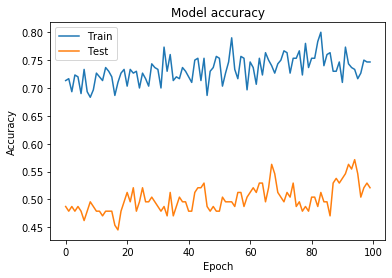


# Evaluate on test data
20/20 [==============================] - 0s 6ms/step - loss: 0.7388 - categorical_crossentropy: 0.7388 - categorical_accuracy: 0.5063
test loss, test acc: [0.7387892246246338, 0.7387892, 0.50625]
X_train shape: (300, 1, 3, 1000)
300 train samples
99 val samples
320 test samples
Train on 19 steps, validate on 7 steps
Epoch 1/100
19/19 [==============================] - 0s 22ms/step - loss: 0.7035 - categorical_crossentropy: 0.7035 - categorical_accuracy: 0.5167 - val_loss: 0.6927 - val_categorical_crossentropy: 0.6927 - val_categorical_accuracy: 0.5051
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6892 - categorical_crossentropy: 0.6892 - categorical_accuracy: 0.5500 - val_loss: 0.6914 - val_categorical_crossentropy: 0.6914 - val_categorical_accuracy: 0.4949
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6825 - categorical_crossentropy: 0.6825 - categorical_accuracy: 0.5833 - val_loss: 0.6904 - val_categor

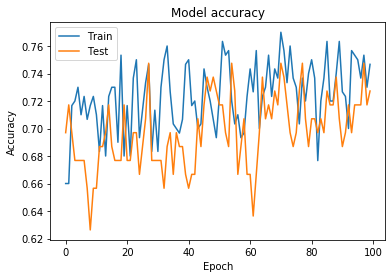


# Evaluate on test data
20/20 [==============================] - 0s 6ms/step - loss: 0.6530 - categorical_crossentropy: 0.6530 - categorical_accuracy: 0.6313
test loss, test acc: [0.6529801577329636, 0.6529802, 0.63125]
X_train shape: (300, 1, 3, 1000)
300 train samples
99 val samples
320 test samples
Train on 19 steps, validate on 7 steps
Epoch 1/100
19/19 [==============================] - 0s 23ms/step - loss: 0.6923 - categorical_crossentropy: 0.6923 - categorical_accuracy: 0.5133 - val_loss: 0.6929 - val_categorical_crossentropy: 0.6929 - val_categorical_accuracy: 0.5051
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6884 - categorical_crossentropy: 0.6884 - categorical_accuracy: 0.5233 - val_loss: 0.6922 - val_categorical_crossentropy: 0.6922 - val_categorical_accuracy: 0.5758
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6862 - categorical_crossentropy: 0.6862 - categorical_accuracy: 0.5733 - val_loss: 0.6924 - val_categor

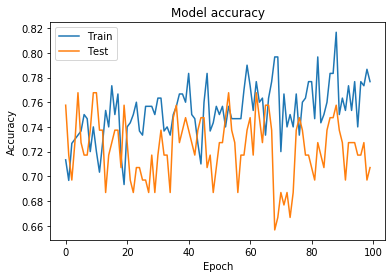


# Evaluate on test data
20/20 [==============================] - 0s 6ms/step - loss: 0.6816 - categorical_crossentropy: 0.6816 - categorical_accuracy: 0.6062
test loss, test acc: [0.6816298544406891, 0.6816298, 0.60625]
X_train shape: (300, 1, 3, 1000)
300 train samples
139 val samples
320 test samples
Train on 19 steps, validate on 9 steps
Epoch 1/100
19/19 [==============================] - 0s 22ms/step - loss: 0.7043 - categorical_crossentropy: 0.7043 - categorical_accuracy: 0.4800 - val_loss: 0.6933 - val_categorical_crossentropy: 0.6933 - val_categorical_accuracy: 0.5180
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6811 - categorical_crossentropy: 0.6811 - categorical_accuracy: 0.5600 - val_loss: 0.6930 - val_categorical_crossentropy: 0.6930 - val_categorical_accuracy: 0.5468
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6762 - categorical_crossentropy: 0.6762 - categorical_accuracy: 0.5967 - val_loss: 0.6935 - val_catego

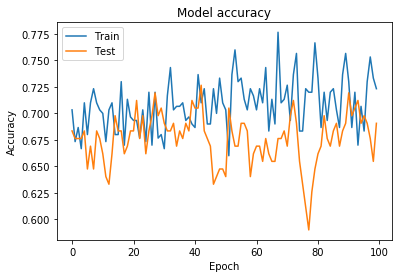


# Evaluate on test data
20/20 [==============================] - 0s 6ms/step - loss: 0.5857 - categorical_crossentropy: 0.5857 - categorical_accuracy: 0.6938
test loss, test acc: [0.5856537416577339, 0.5856537, 0.69375]
X_train shape: (300, 1, 3, 1000)
300 train samples
99 val samples
320 test samples
Train on 19 steps, validate on 7 steps
Epoch 1/100
19/19 [==============================] - 0s 22ms/step - loss: 0.6955 - categorical_crossentropy: 0.6955 - categorical_accuracy: 0.5233 - val_loss: 0.6922 - val_categorical_crossentropy: 0.6922 - val_categorical_accuracy: 0.6061
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6831 - categorical_crossentropy: 0.6831 - categorical_accuracy: 0.5467 - val_loss: 0.6924 - val_categorical_crossentropy: 0.6924 - val_categorical_accuracy: 0.5455
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6881 - categorical_crossentropy: 0.6881 - categorical_accuracy: 0.5233 - val_loss: 0.6924 - val_categor

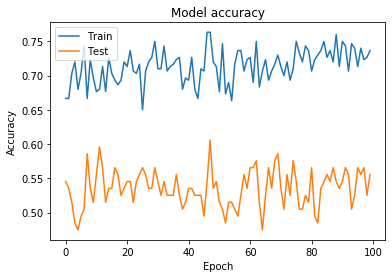


# Evaluate on test data
20/20 [==============================] - 0s 6ms/step - loss: 0.6908 - categorical_crossentropy: 0.6908 - categorical_accuracy: 0.5656
test loss, test acc: [0.6908494800329208, 0.6908494, 0.565625]
[[0.71552801 0.53214288]
 [0.71447527 0.546875  ]
 [0.4163402  0.80312502]
 [0.7387892  0.50625002]
 [0.65298021 0.63125002]
 [0.68162978 0.60624999]
 [0.58565372 0.69375002]
 [0.69084942 0.56562501]
 [0.71653146 0.56562501]]


<Figure size 432x288 with 0 Axes>

In [12]:
K.clear_session()
cols = 2
rows = 9
nsl_acc_all = zeros([rows, cols])
for s, sub in enumerate(subjects.values()):
  # split data of each subject in training and validation
  X_train      = np.asarray(train_data[s])[0:300,:,:]
  Y_train      = np.asarray(train_label[s])[0:300]
  X_val       = np.asarray(train_data[s])[301:,:,:]
  Y_val       = np.asarray(train_label[s])[301:]
  X_test      = np.asarray(test_data[s])
  Y_test      = np.asarray(test_label[s])
  
  # convert labels to one-hot encodings.
  Y_train      = np_utils.to_categorical(Y_train-1)
  Y_val       = np_utils.to_categorical(Y_val-1)
  Y_test      = np_utils.to_categorical(Y_test-1)

  kernels, chans, samples = 1, 3, 1000
  # convert data to NCHW (trials, kernels, channels, samples) format. Data 
  # contains 22 channels and 500 time-points. Set the number of kernels to 1.
  X_train      = X_train.reshape(X_train.shape[0], kernels, chans, samples)
  X_val       = X_val.reshape(X_val.shape[0], kernels, chans, samples)
  X_test       = X_test.reshape(X_test.shape[0], kernels, chans, samples)
   
  print('X_train shape:', X_train.shape)
  print(X_train.shape[0], 'train samples')
  print(X_val.shape[0], 'val samples')
  print(X_test.shape[0], 'test samples')

  # configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
  # model configurations may do better, but this is a good starting point)
  model = EEGNet(nb_classes = 2, Chans = 3, Samples = 1000, 
                 dropoutRate = 0.5, kernLength = 25, F1 = 8, 
                 D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')
  
  adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.2, adv_grad_norm='infinity')
  adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)
  
  # compile the model and set the optimizers
  adv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  batch_size = 16

  X_train = tf.cast(X_train, tf.float32)
  X_test = tf.cast(X_test, tf.float32)
  X_val = tf.cast(X_val, tf.float32)

  xtrain_data = tf.data.Dataset.from_tensor_slices({'input': X_train, 'label': Y_train}).batch(batch_size)
  xval_data = tf.data.Dataset.from_tensor_slices({'input': X_val, 'label': Y_val}).batch(batch_size)
  xtest_data = tf.data.Dataset.from_tensor_slices({'input': X_test, 'label': Y_test}).batch(batch_size)

  val_steps = X_val.shape[0] // batch_size
  
  adv_model.fit(xtrain_data, validation_data=xval_data, validation_steps=None, epochs=100, verbose=1)

  history = adv_model.fit(xtrain_data, validation_data=xval_data, validation_steps=None, epochs=100, verbose=1)

  # Plot training & validation accuracy values
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  figName = 'Accuracy_A0' + sub + '.png'  
  plt.savefig(figName)

  print('\n# Evaluate on test data')
  results = adv_model.evaluate(xtest_data)
  print('test loss, test acc:', results)

  nsl_acc_all[s - 1, 0] = results[1]
  nsl_acc_all[s - 1, 1] = results[2]

  from keras import backend as K 
  # Do some code, e.g. train and save model
  K.clear_session()


print(nsl_acc_all)


In [13]:
print(acc_all[:,1], nsl_acc_all[:,1])

[0.50714284 0.55000001 0.78437501 0.50937498 0.60624999 0.69375002
 0.734375   0.57187498 0.60624999] [0.53214288 0.546875   0.80312502 0.50625002 0.63125002 0.60624999
 0.69375002 0.56562501 0.56562501]
